# Customer Churn Prediction

**Author**: Arnav Sharma - arnav.sharma2264@gmail.com - github.com/ArnavSharma2
**Date**: 2025-08-30 
**Description**: WIP

## Table of Contents
1. [Project Setup](#1-project-setup)
2. [Data Loading](#2-data-loading)
3. [Exploratory Data Analysis (EDA)](#3-exploratory-data-analysis-eda)
4. [Data Preprocessing](#4-data-preprocessing)
5. [Feature Engineering](#5-feature-engineering)
6. [Model Training](#6-model-training)
7. [AutoML](#7-automl)
8. [Deep Learning](#8-deep-learning)
9. [Model Evaluation](#9-model-evaluation)
10. [Hyperparameter Tuning](#10-hyperparameter-tuning)
11. [Model Interpretation](#11-model-interpretation)
12. [Model Deployment](#12-model-deployment)
13. [Conclusion and Next Steps](#13-conclusion-and-next-steps)

## 1. Project Setup
Install and import necessary libraries, set random seeds for reproducibility, and configure project settings.

In [53]:
# Install required packages (uncomment to install)
# !pip install -r requirements.txt

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from xgboost import XGBClassifier, XGBRegressor
# from flaml import AutoML
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping
import shap
# from skopt import BayesSearchCV
from joblib import dump, load 
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
# tf.random.set_seed(42)

PATH = os.getcwd()
DATA_PATH = os.path.join(PATH, "Dataset/TelcoCustomer-Churn.csv")

# Define project-specific variables
# DATA_PATH = "/Users/aps/Desktop/ML-DL-Projects/01-housepriceprediction/Dataset/HousePrices.csv"  # Update with your dataset path
TARGET_COLUMN = "Churn"  # Update with your target column name
# DROP_COLUMNS = ['yr_renovated', 'yr_built', 'condition', 'sqft_lot', 'country', 'waterfront', 'floors', 'date','street'] # list of columns to drop
DROP_COLUMNS = ['customerID']
HANDLE_OUTLIERS = []
TASK_TYPE = "regression"  # Options: "classification" or "regression"
MODEL_SAVE_PATH = "model.pkl"

## 2. Data Loading
Load the dataset and perform initial checks for data integrity.

In [ ]:
def load_data(file_path):
    """
    Load dataset from a given file path.
    
    Parameters:
    file_path (str): Path to the dataset (CSV, Excel, etc.)
    
    Returns:
    pandas.DataFrame: Loaded dataset
    """
    try:
        if file_path.endswith('.csv'):
            data = pd.read_csv(file_path)
        elif file_path.endswith('.xlsx'):
            data = pd.read_excel(file_path)
        else:
            raise ValueError("Unsupported file format")
        
        print("Data loaded successfully!")
        print(f"Shape: {data.shape}")
        print("\nFirst 5 rows:")
        print(data.head())
        print("\nData Info:")
        print(data.info())
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Load the dataset
df = load_data(DATA_PATH)
if df is None:
    raise SystemExit("Data loading failed. Exiting.")

Data loaded successfully!
Shape: (7043, 21)


## 3. Exploratory Data Analysis (EDA)
Understand the dataset through visualizations and statistical summaries.


Summary Statistics:
        customerID gender  SeniorCitizen Partner Dependents       tenure  \
count         7043   7043    7043.000000    7043       7043  7043.000000   
unique        7043      2            NaN       2          2          NaN   
top     7590-VHVEG   Male            NaN      No         No          NaN   
freq             1   3555            NaN    3641       4933          NaN   
mean           NaN    NaN       0.162147     NaN        NaN    32.371149   
std            NaN    NaN       0.368612     NaN        NaN    24.559481   
min            NaN    NaN       0.000000     NaN        NaN     0.000000   
25%            NaN    NaN       0.000000     NaN        NaN     9.000000   
50%            NaN    NaN       0.000000     NaN        NaN    29.000000   
75%            NaN    NaN       0.000000     NaN        NaN    55.000000   
max            NaN    NaN       1.000000     NaN        NaN    72.000000   

       PhoneService MultipleLines InternetService OnlineSecurity  

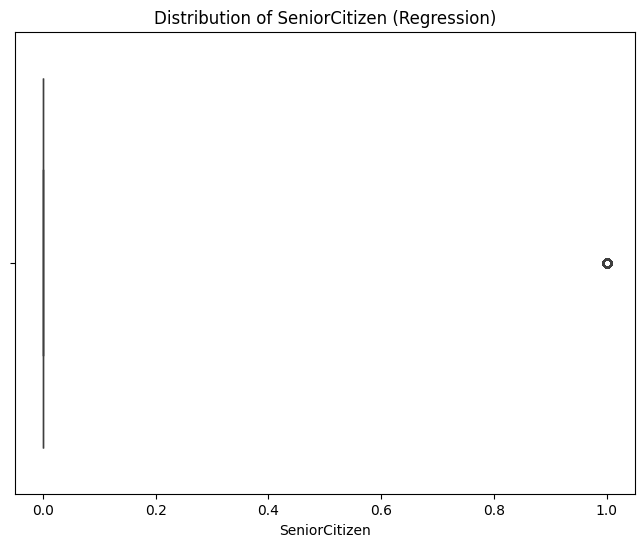

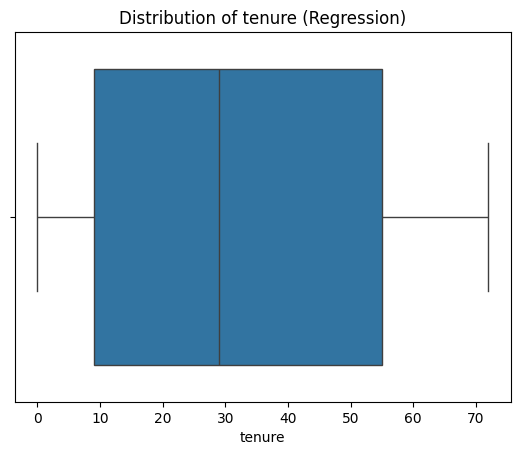

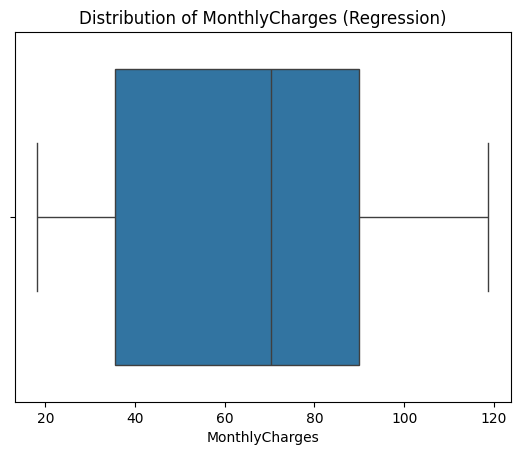

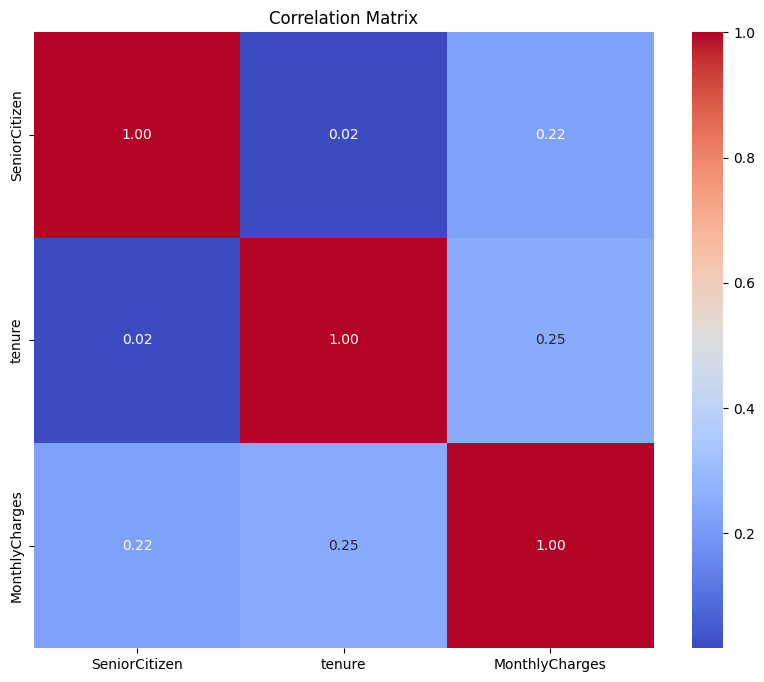

In [56]:
def perform_eda(df, target_column):
    """
    Perform exploratory data analysis on the dataset.
    
    Parameters:
    df (pandas.DataFrame): Input dataset
    target_column (str): Name of the target column
    """
    # Summary statistics
    print("\nSummary Statistics:")
    print(df.describe(include='all'))
    
    # Missing values
    print("\nMissing Values:")
    print(df.isnull().sum())

    # Grab all the numerical cols
    num_cols = df.select_dtypes(include=[np.number]).columns
    
    # Distribution of target variable
    plt.figure(figsize=(8, 6))
    if TASK_TYPE == "classification":
        sns.countplot(x=target_column, data=df)
        plt.title(f"Distribution of {target_column}")
    else:
        # sns.histplot(df[target_column], kde=True)
        for col in num_cols:
            sns.boxplot(x=df[col])
            plt.title(f"Distribution of {col} (Regression)")
            plt.show()
    
    # Correlation matrix (for numeric columns)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Matrix")
    plt.show()
    
    # Pairplot for numeric features (optional, for smaller datasets)
    # sns.pairplot(df[numeric_cols])
    # plt.show()

# Perform EDA
perform_eda(df, TARGET_COLUMN)

## 4. Data Preprocessing
Clean the data and prepare it for modeling.

In [ ]:
def get_label_and_ohe(df):
    LABEL_ENCODING = []
    ONE_HOT_ENCODING = []
    for col in df:
        #print(f"{col} has {len(df[col].unique())} unique values and {df[col].isnull().sum()} null values")

        if len(df[col].unique()) < 3 and len(df[col].unique()) > 1:
            LABEL_ENCODING.append(''.join(col))
        elif df[col].dtype == object:
            ONE_HOT_ENCODING.append(''.join(col))
    return LABEL_ENCODING, ONE_HOT_ENCODING

def transform_with_ohe(ohe_df, colname):
    ohe = OneHotEncoder(drop=None, sparse_output=False)
    ohe1 = ohe.fit_transform(ohe_df[[colname]])
    ohe2 = pd.DataFrame(ohe1, columns=ohe.get_feature_names_out([colname]), index=ohe_df.index)
    transformed = pd.concat([ohe_df.drop(colname, axis=1), ohe2], axis=1)
    transformed.head()
    return transformed

def transform_with_le(df, col):
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    return df

def remove_any_outliers(outlier_df, colname):
    # This line of code keeps only the middle 98% of price values and removes the most extreme 2% (lowest 1% + highest 1%) from your dataset.
    # Keeps only the rows where price is greater than the 1st percentile and less than the 99th percentile.
    # In other words, it removes the extreme 1% lowest and 1% highest values.
    high = 0.99
    low = 1-high

    removed_outliers = outlier_df[(outlier_df[colname] > outlier_df[colname].quantile(low)) & 
                        (outlier_df[colname] < outlier_df[colname].quantile(high))]
    removed_outliers.columns
    # Plot the Before and After graph
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # Before
    sns.boxplot(x=outlier_df[colname], ax=axes[0])
    axes[0].set_title("Before Removing Outliers")
    # After
    sns.boxplot(x=removed_outliers[colname], ax=axes[1])
    axes[1].set_title("After Removing Outliers")
    plt.show()
    return removed_outliers


def preprocess_data(df, target_column):
    """
    Preprocess the dataset (handle missing values, encode categorical variables, etc.).
    
    Parameters:
    df (pandas.DataFrame): Input dataset
    target_column (str): Name of the target column
    
    Returns:
    pandas.DataFrame: Preprocessed dataset
    """
    # # Separate features and target
    # X = df.drop(columns=[target_column])
    # y = df[target_column]
    
    # removing unimportant features
    processed = df.drop(DROP_COLUMNS, axis=1)
    labelencoding, onehotencoding = get_label_and_ohe(processed)
    # Handle missing values
    numeric_cols = processed.select_dtypes(include=[np.number]).columns
    categorical_cols = processed.select_dtypes(include=['object', 'category']).columns

    
    # Impute numeric columns with median
    for col in numeric_cols:
        processed[col].fillna(processed[col].median(), inplace=True)
    
    # Impute categorical columns with mode, Grab the final DF before OHE so we can do SHAP
    for col in categorical_cols:
        SHAP_DF = processed[col].fillna(processed[col].mode()[0], inplace=True)

    
    
    # Encode categorical variables
    # le = LabelEncoder()
    # for col in categorical_cols:
    #     X[col] = le.fit_transform(X[col])

    # Scale the numerical columns
    scaler = StandardScaler()
    numeric_cols = processed.select_dtypes(include=[np.number]).columns
    processed[numeric_cols] = scaler.fit_transform(processed[numeric_cols])

    # This project will require One Hot encoding on City and statezip
    for col in onehotencoding:
        processed = transform_with_ohe(processed, col)
    
    for col in labelencoding:
        processed = transform_with_le(processed, col)
    
    # Handle any outlier needs
    for col in HANDLE_OUTLIERS:
        processed = remove_any_outliers(processed,col)

    # split into X and Y DF
    X = processed.drop(TARGET_COLUMN,axis=1)
    y = processed[TARGET_COLUMN]

    print("Data preprocessing completed!")
    return X, y, scaler


# Preprocess data
X, y, scaler = preprocess_data(df, TARGET_COLUMN)


Data preprocessing completed!


## 5. Feature Engineering
Create new features and scale the data.

In [ ]:

# def feature_engineering(X):
#     # """
#     # Perform feature engineering (e.g., creating new features, scaling).
    
#     # Parameters:
#     # X (pandas.DataFrame): Feature dataset
    
#     # Returns:
#     # pandas.DataFrame: Engineered feature dataset
#     # """
#     # # Example: Create interaction features (customize as needed)
#     # if 'feature1' in X.columns and 'feature2' in X.columns:
#     #     X['feature1_feature2_interaction'] = X['feature1'] * X['feature2']
    
#     # Scale numeric features
#     scaler = StandardScaler()
#     numeric_cols = X.select_dtypes(include=[np.number]).columns
#     numeric_cols
#     X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
    
#     # print("Feature engineering completed!")
#     return X, scaler

#     # Implementing One Hot Encoder on City and Statezip
#     ohe = OneHotEncoder(drop=None, sparse_output=False)
#     city_ohe = ohe.fit_transform(d[['city']])

#     city_df = pd.DataFrame(city_ohe, columns=ohe.get_feature_names_out(['city']), index=X.index)

#     return pd.concat([X.drop('city', axis=1), city_df], axis=1)



# # Perform feature engineering
# X = feature_engineering(X)

## 6. AutoML
Use an AutoML framework (FLAML) to automatically select and tune the best model for the task.

In [ ]:
from flaml import AutoML

def run_automl(X_train, y_train, task_type, time_budget=60):
    """
    Run AutoML using FLAML to automatically select and tune the best model.
    
    Parameters:
    X_train (pandas.DataFrame): Training features
    y_train (numpy.array): Training target
    task_type (str): 'classification' or 'regression'
    time_budget (int): Time budget in seconds for AutoML (default: 60)
    
    Returns:
    model: Best AutoML model
    """
    automl = AutoML()
    automl_settings = {
        "time_budget": time_budget,  # Time budget in seconds
        "metric": "accuracy" if task_type == "classification" else "rmse",
        "task": task_type,
        "log_file_name": "automl.log",
        "n_jobs": -1,
        "random_state": 42
    }
    
    automl.fit(X_train=X_train, y_train=y_train, **automl_settings)
    print(f"Best AutoML model: {automl.best_estimator}")
    print(f"Best configuration: {automl.best_config}")
    
    return automl

# Run AutoML
#automl_model = run_automl(X_train, y_train, TASK_TYPE, time_budget=60)


## 7. Model Training
Split data and train multiple models.

In [ ]:
def train_models(X, y):
    """
    Train multiple machine learning models, AutoML, and a deep learning model.
    
    Parameters:
    X (pandas.DataFrame): Features
    y (numpy.array): Target
    
    Returns:
    dict: Trained models (including AutoML and Deep Learning)
    """
    # Split data into train and test sets
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    # Initialize models based on task type
    models = {}
    if TASK_TYPE == "classification":
        models['Logistic Regression'] = LogisticRegression(random_state=42)
        models['Random Forest'] = RandomForestClassifier(random_state=42)
        models['XGBoost'] = XGBClassifier(random_state=42)
    else:
        models['Linear Regression'] = LinearRegression()
        models['Random Forest'] = RandomForestRegressor(random_state=42)
        models['XGBoost'] = XGBRegressor(random_state=42)

    # Train manual models
    for name, model in models.items():
        model.fit(X_train, y_train)
        print(f"{name} trained successfully!")
    
    # Run AutoML
    #automl_model = run_automl(X_train, y_train, TASK_TYPE, time_budget=60)
    #models['AutoML'] = automl_model

    
    return models, X_train, X_test, y_train, y_test

# Train models
models, X_train, X_test, y_train, y_test = train_models(X, y)

## 8. Model Evaluation
Evaluate models using appropriate metrics.

In [ ]:
def model_weights(mod):
    # 3. Access and print the weights
    weights = mod.coef_
    intercept = mod.intercept_

    print(f"Weights (Coefficients): {weights}")
    print(f"Intercept: {intercept}")

    # 4. Optional: Create a DataFrame for better readability
    # This pairs each weight with its corresponding feature name
    weights_df = pd.DataFrame({'Feature': X.columns, 'Weight': weights})
    print("\nModel Weights:")
    print(weights_df)

def evaluate_models(models, X_test, y_test):
    """
    Evaluate trained models using appropriate metrics.
    
    Parameters:
    models (dict): Dictionary of trained models
    X_test (pandas.DataFrame): Test features
    y_test (numpy.array): Test target
    """
    results = {}
    
    for name, model in models.items():
        if name == 'Deep Learning':
            y_pred = model.predict(X_test)
            y_pred = (y_pred > 0.5).astype(int).flatten() if TASK_TYPE == "classification" else y_pred.flatten()
        else:
            y_pred = model.predict(X_test)
        
        if TASK_TYPE == "classification":
            results[name] = {
                'Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred, average='weighted'),
                'Recall': recall_score(y_test, y_pred, average='weighted'),
                'F1 Score': f1_score(y_test, y_pred, average='weighted')
            }
        else:
            results[name] = {
                'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
                'R2 Score': r2_score(y_test, y_pred)
            }
    

    
    # Display results
    results_df = pd.DataFrame(results).T
    print("\nModel Evaluation Results:")
    print(results_df)
    
    return results_df

# Evaluate models
results_df = evaluate_models(models, X_test, y_test)

## 9. Hyperparameter Tuning
Optimize the best-performing model using Bayesian optimization.

In [ ]:


def tune_best_model(X_train, y_train, best_model_name, models):
    """
    Perform hyperparameter tuning on the best model (excluding AutoML and Deep Learning).
    
    Parameters:
    X_train (pandas.DataFrame): Training features
    y_train (numpy.array): Training target
    best_model_name (str): Name of the best model
    models (dict): Dictionary of trained models
    
    Returns:
    model: Tuned model
    """
    # Define hyperparameter search space (customize as needed)
    param_space = {
        'Random Forest': {
            'n_estimators': (10, 200),
            'max_depth': (3, 20),
            'min_samples_split': (2, 10)
        },
        'XGBoost': {
            'n_estimators': (10, 200),
            'max_depth': (3, 20),
            'learning_rate': (0.01, 0.3, 'log-uniform')
        }
    }
    
    if best_model_name in param_space:
        bayes_cv = BayesSearchCV(
            estimator=models[best_model_name],
            search_spaces=param_space[best_model_name],
            n_iter=20,
            cv=5,
            n_jobs=-1,
            random_state=42
        )
        bayes_cv.fit(X_train, y_train)
        print(f"Best parameters for {best_model_name}: {bayes_cv.best_params_}")
        return bayes_cv.best_estimator_
    elif best_model_name in ['AutoML', 'Deep Learning']:
        print(f"{best_model_name} model is already tuned or does not support BayesSearchCV. Skipping additional tuning.")
        return models[best_model_name]
    else:
        print(f"No tuning defined for {best_model_name}")
        return models[best_model_name]

# Select the best model (based on evaluation metrics)
best_model_name = results_df.idxmax()['Accuracy' if TASK_TYPE == "classification" else 'R2 Score']
tuned_model = tune_best_model(X_train, y_train, best_model_name, models)


## 10. Model Interpretation
Interpret the model using SHAP values.

In [ ]:
# def interpret_model(model, X_train, model_name):
#     """
#     Interpret the model using SHAP values.
    
#     Parameters:
#     model: Trained model
#     X_train (pandas.DataFrame): Training features
#     model_name (str): Name of the model
#     """
#     try:
#         if model_name in ['Random Forest', 'XGBoost']:
#             explainer = shap.TreeExplainer(model)
#             shap_values = explainer.shap_values(X_train)
#         elif model_name == 'AutoML':
#             # Check if the AutoML model is tree-based
#             if 'rf' in model.best_estimator.lower() or 'xgboost' in model.best_estimator.lower():
#                 explainer = shap.TreeExplainer(model.model)
#                 shap_values = explainer.shap_values(X_train)
#             else:
#                 explainer = shap.KernelExplainer(model.predict, X_train)
#                 shap_values = explainer.shap_values(X_train)
#         elif model_name == 'Deep Learning':
#             explainer = shap.DeepExplainer(model, X_train)
#             shap_values = explainer.shap_values(X_train.to_numpy())
#         else:
#             explainer = shap.KernelExplainer(model.predict, X_train)
#             shap_values = explainer.shap_values(X_train)
        
#         # Summary plot
#         shap.summary_plot(shap_values, X_train, plot_type="bar")
#         plt.title(f"Feature Importance (SHAP) - {model_name}")
#         plt.show()
#     except Exception as e:
#         print(f"SHAP interpretation failed for {model_name}: {e}")

# # Interpret the best model
# interpret_model(tuned_model, X_train, best_model_name)

## 11. Model Deployment
Save the model and create a prediction function for deployment.

In [ ]:
def save_model(model, scaler, path, model_name):
    """
    Save the trained model and scaler.
    
    Parameters:
    model: Trained model
    scaler: Fitted scaler
    path (str): Path to save the model
    model_name (str): Name of the model
    """
    if model_name == 'Deep Learning':
        model.save(path.replace('.pkl', '.h5'))  # Save Keras model in HDF5 format
        dump({'scaler': scaler}, path.replace('.pkl', '_scaler.pkl'))
        print(f"Deep Learning model saved to {path.replace('.pkl', '.h5')}")
        print(f"Scaler saved to {path.replace('.pkl', '_scaler.pkl')}")
    else:
        dump({'model': model, 'scaler': scaler}, path)
        print(f"Model and scaler saved to {path}")

def predict_new_data(model, scaler, new_data, model_name):
    """
    Make predictions on new data.
    
    Parameters:
    model: Trained model
    scaler: Fitted scaler
    new_data (pandas.DataFrame): New data for prediction
    model_name (str): Name of the model
    
    Returns:
    numpy.array: Predictions
    """
    # Preprocess new data
    numeric_cols = new_data.select_dtypes(include=[np.number]).columns
    new_data[numeric_cols] = scaler.transform(new_data[numeric_cols])
    
    # Make predictions
    if model_name == 'Deep Learning':
        predictions = model.predict(new_data).flatten()
        if TASK_TYPE == "classification":
            predictions = (predictions > 0.5).astype(int)
    else:
        predictions = model.predict(new_data)
    return predictions

# Save the model
save_model(tuned_model, scaler, MODEL_SAVE_PATH, best_model_name)

# Example: Predict on new data (replace with actual new data)
# new_data = pd.DataFrame(...)  # Load or create new data
# predictions = predict_new_data(tuned_model, scaler, new_data, best_model_name)
# print("Predictions on new data:", predictions)

## 12. Conclusion and Next Steps
- **Summary**: Summarize the findings, best model performance (including AutoML and Deep Learning results), and key insights from EDA and model interpretation.
- **Next Steps**: Consider additional feature engineering, trying other AutoML frameworks, experimenting with different neural network architectures, or deploying the model in a production environment.
- **Monitoring**: Plan for model monitoring and retraining to handle data drift.

```python
print("End-to-End ML and Deep Learning Project Completed!")
```

In [ ]:
print("End-to-End ML and Deep Learning Project Completed!")